# Final Report
## Pacman Using DQN

### Course: Reinforcement Leearning Programming
### Course Code : CSCN8020
### Section: 1


## **Team Members (Group-5)**:

- **Harika Ravi** - 9032698
- **Nasr Alani** - 9039537
- **Paljeet Singh Sambhi** - 8918495   
- **Priyanka Chitikela** - 8909667

### Installing Required Libraries

In [ ]:
!pip install gymnasium[atari] AutoROM
!pip install torch torchvision
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install imageio
!pip install ale-py
!pip install ipython
!AutoROM --accept-license


AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/bank_heist.bin
Inst

### Importing the required libraries

In [ ]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import collections
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from IPython.display import HTML
import base64
import ale_py
from google.colab import drive
import imageio

### 1. Mounting Google drive & Initializing Checkpoint Directory

In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/pacman/dqn_checkpoints'
    print("Running in Google Colab — Drive mounted.")
except ImportError:
    IN_COLAB = False
    CHECKPOINT_DIR = './checkpoints/pacman'
    print("Running on local machine — Using local checkpoint directory.")

# Create the checkpoint directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")


Mounted at /content/drive
cuda


### 2. Enviornment Information

Action Space: Discrete(9)
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Reward Range not defined, calculating...
Number of possible actions: 9
Action Meanings: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
Initial Observation Shape: (210, 160, 3)


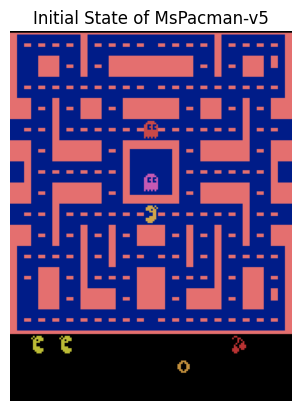

Action Taken: 1
Reward Received: 0.0
Game Over?: False
Additional Info: {'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


In [ ]:
# Check what info we are getting from the enviornment
# Load the environment
env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")

# Print action and observation space
print("Action Space:", env.action_space)  # Possible actions
print("Observation Space:", env.observation_space)  # Shape of input images

# Directly access the reward range
if hasattr(env, 'reward_range'):
    print("Reward Range:", env.reward_range)
else:
    print("Reward Range not defined, calculating...")

# Get number of actions
print("Number of possible actions:", env.action_space.n)

# Get action meanings
print("Action Meanings:", env.unwrapped.get_action_meanings())

# Reset the environment
obs, info = env.reset()
print("Initial Observation Shape:", obs.shape)

# Render and display the initial state
plt.imshow(obs)
plt.axis("off")
plt.title("Initial State of MsPacman-v5")
plt.show()

# Take a random action
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# Print step details
print(f"Action Taken: {action}")
print(f"Reward Received: {reward}")
print(f"Game Over?: {terminated}")
print(f"Additional Info: {info}")

# Close the environment
env.close()


### 3. Checking What Unique Rewards The Agent Gets From The Enviornment

In [ ]:
#Check the unique rewards agent is getting

# Load the environment
env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")

# Initialize reward tracking
min_reward, max_reward = float("inf"), float("-inf")
all_rewards = set()

# Run multiple episodes to capture a wider range of rewards
num_episodes = 100

for episode in range(num_episodes):
    obs, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Take a random action
        obs, reward, terminated, truncated, info = env.step(action)

        # Update reward tracking
        min_reward = min(min_reward, reward)
        max_reward = max(max_reward, reward)
        all_rewards.add(reward)

        # Check if game is over
        done = terminated or truncated

# Print final computed reward range
print(f"Computed Reward Range after {num_episodes} episodes: ({min_reward}, {max_reward})")
print("Unique rewards observed:", sorted(all_rewards))

# Close the environment
env.close()


Computed Reward Range after 100 episodes: (0.0, 200.0)
Unique rewards observed: [0.0, 10.0, 50.0, 200.0]


#### **<u>Interpretation</u>**
- For small pellets agent gets 10 reward
- For power up pellet agent gets 50 reward
- For eating the ghost agent gets 200 reward

### 4. Preprocessing of the frames
#### **<u>Explanation</u>**
- First convert the frame to gray scale
- Second resize it to 84 X 84
- Third normalize the pixels

In [ ]:
# Preprocess frames: grayscale, resize, normalize
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84))
    frame = np.array(frame, dtype=np.float32) / 255.0
    return frame

### 5. Replay Buffer Class
1. **Creates a Memory Storage**  
   The `ReplayBuffer` class sets up a memory structure to store past experiences (state, action, reward, next state, done) during training. It uses a limited-size queue to automatically remove the oldest data when full.

2. **Adds New Experiences**  
   The `add` function inserts a new experience into the memory. Each experience is a combination of what the agent saw, what it did, what it got, what happened next, and whether the episode ended.

3. **Samples Experiences for Learning**  
   The `sample` function randomly selects a group of past experiences (batch) from memory and converts them into tensors so the machine learning model can use them for training.

4. **Checks Memory Size**  
   The `size` function simply returns how many experiences are currently stored in the buffer. This helps in checking if enough data is available for training.

In [ ]:
# Replay Memory
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
        )

    def size(self):
        return len(self.buffer)

### 6. DQN Class
#### **<u>Explanation of DQN Model Code</u>**

1. **Defines a Deep Q-Network (DQN) Model**  
   The `DQN` class is a neural network that helps an AI agent learn to make decisions (choose actions) based on what it sees (its input). It's built using PyTorch and inherits from `nn.Module`.

2. **Processes Images with Convolutional Layers**  
   The `self.conv` part is a sequence of 3 convolutional layers. These layers extract important patterns from image-based inputs (like game frames) using filters and activation functions (`ReLU`).

3. **Uses Fully Connected Layers to Make Decisions**  
   The `self.fc` part takes the processed image data and passes it through two fully connected (linear) layers. The final layer outputs a value (Q-value) for each possible action, showing how good each action is.

4. **Defines the Forward Pass**  
   The `forward` function tells the model how to compute its output: first by passing the input through the convolutional layers, then flattening the result, and finally sending it through the fully connected layers to get the action values.


In [ ]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### 7. Save Checkpoint
#### **<u>Explanation of `save_checkpoint` Function</u>**

1. **Purpose of the Function**  
   This function saves the current state of the training process (models, optimizer, episode number, and epsilon value) so that training can be resumed later from this point.

2. **Builds the File Path**  
   The line `checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)` creates the full path where the checkpoint file will be saved.

3. **Removes Old Checkpoint**  
   If a checkpoint file with the same name already exists, it is deleted first to avoid confusion and ensure only the latest one is stored.

4. **Saves the New Checkpoint**  
   The function uses `torch.save` to store the episode number, model weights (`state_dict`), optimizer state, and current exploration rate (`epsilon`) into a file. This allows the training to continue later from exactly where it left off.


In [ ]:
# Function to save the checkpoint
def save_checkpoint(policy_model, target_model, optimizer, episode, epsilon, filename="checkpoint.pth"):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)

    # Delete previous checkpoint if it exists
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)

    # Save the new checkpoint
    torch.save({
        'episode': episode,
        'policy_model_state_dict': policy_model.state_dict(),
        'target_model_state_dict': target_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon  # Save epsilon
    }, checkpoint_path)
    print(f"Checkpoint saved at episode {episode} to {checkpoint_path}")

### 8. Load Checkpoint
#### **<u>Explanation of `load_checkpoint` Function</u>**

1. **Purpose of the Function**  
   This function loads a previously saved checkpoint so that training can continue from where it left off. It restores the model states, optimizer, episode number, and epsilon value.

2. **Checks for Existing Checkpoint**  
   It first builds the full path using the given filename and checks if the checkpoint file exists in the specified directory.

3. **Loads Saved Training State**  
   If the file is found, it loads the saved data using `torch.load`. It then restores the states of the policy model, target model, and optimizer, as well as the last saved episode and exploration rate (`epsilon`).

4. **Handles Missing Checkpoint**  
   If the checkpoint doesn't exist, it prints a message and returns default values (episode = 0, epsilon = 1.0), meaning the training will start fresh.


In [ ]:
# Function to load the latest checkpoint
def load_checkpoint(policy_model, target_model, optimizer, filename="checkpoint.pth"):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
        target_model.load_state_dict(checkpoint['target_model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epsilon = checkpoint['epsilon']  # Load epsilon
        episode = checkpoint['episode']
        print(f"Checkpoint loaded from episode {episode} with epsilon {epsilon} at {checkpoint_path}")
        return episode,epsilon
    else:
        print("No checkpoint found, starting from scratch.")
        return 0,1.0  # If no checkpoint exists, start from episode 0

### 9. Training the Agent
#### **<u>Explanation of `train` Function</u>**

1. **Setup and Initialization**  
   - The function sets up the game environment (`MsPacman`), builds neural networks (`policy_net` and `target_net`), an optimizer, and a replay buffer to store experiences.
   - It checks for a saved checkpoint to continue training from the last state.

2. **Episode Loop**  
   - The agent plays the game for multiple episodes.
   - For each step, it decides to either explore (random action) or exploit (use model prediction), then stores the experience.

3. **Training the Agent**  
   - Once enough experiences are stored, a batch is sampled from the buffer.
   - The model is trained using the difference between current predictions and expected future rewards (Q-learning).

4. **Target Network & Epsilon Decay**  
   - The target network is updated periodically for stable learning.
   - The epsilon value, which controls randomness in actions, is slowly reduced to focus more on the learned behavior.

5. **Saving Progress and Visualizing**  
   - Model checkpoints are saved every 100 episodes.
   - At the end, training progress is visualized using graphs showing reward, win rate, step count, training loss, and epsilon over time.


In [ ]:
# Training function
def train(GAMMA, LEARNING_RATE, BUFFER_SIZE, BATCH_SIZE, TARGET_UPDATE, WIN_REWARD_THRESHOLD, EPSILON_MIN, EPSILON_DECAY, NUM_EPISODES, FRAME_STACK,FILENAME='pacman_dqn_experiment_1.pth'):

    if(IN_COLAB):
      model_path = os.path.join("/content/drive/MyDrive/pacman", FILENAME)
    else:
      model_path = os.path.join("./", FILENAME)

    if os.path.exists(model_path):
      os.remove(model_path)
    env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    state_shape = (FRAME_STACK, 84, 84)
    num_actions = env.action_space.n

    policy_net = DQN(state_shape, num_actions).to(device)
    target_net = DQN(state_shape, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    replay_buffer = ReplayBuffer(BUFFER_SIZE)

    # Load checkpoint if it exists
    episode_num, epsilon = load_checkpoint(policy_net, target_net, optimizer)


    rewards_per_episode = []  # Track reward per episode
    step_per_episode = []  # Track step count per episode
    wins_per_episode = []  # Track win rate per episode
    loss_per_episode = []  # Track loss per episode
    epsilon_per_episode = []  # Track epsilon per episode
    wins = 0  # Count of wins
    total_episodes = 0  # Count of total episodes
    total_step_count = 0
    total_rewards = 0
    total_steps = 0

    # Main training loop
    for episode in range(episode_num, NUM_EPISODES):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state_stack = collections.deque([state] * FRAME_STACK, maxlen=FRAME_STACK)
        state_stack_array  = np.array(state_stack)
        episode_reward = 0
        episode_step_count = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.from_numpy(state_stack_array).float().unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(dim=1).item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state_stack = state_stack.copy()
            next_state_stack.append(next_state)

            replay_buffer.add(np.array(state_stack), action, reward, np.array(next_state_stack), done)

            state_stack = next_state_stack
            episode_reward += reward
            episode_step_count += 1
            total_step_count += 1

            if replay_buffer.size() > BATCH_SIZE:
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(dim=1)[0]
                    expected_q_values = rewards + GAMMA * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q_values)
                loss_per_episode.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if total_step_count % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards_per_episode.append(episode_reward)

        #check for win
        if episode_reward >= WIN_REWARD_THRESHOLD:
            wins += 1

        total_episodes += 1
        win_rate = wins / total_episodes
        wins_per_episode.append(win_rate)  # Store win rate for each episode
        total_rewards += episode_reward
        total_steps += episode_step_count
        step_per_episode.append(episode_step_count)
        epsilon_per_episode.append(epsilon)

        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        if (episode + 1) % 100 == 0:
          #q_values_np = policy_net(state_tensor).cpu().detach().numpy()
          #q_values.append(q_values_np)
          avg_reward = total_rewards / 100
          avg_steps = total_steps / 100
          print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, Avg Steps = {avg_steps:.2f}, Epsilon = {epsilon:.4f}")

          # Reset for next 100 episodes
          total_rewards = 0
          total_steps = 0
          #print(f"Episode {episode + 1}: Reward = {episode_reward}, Epsilon = {epsilon:.4f}, Episode Step Count = {episode_step_count} Total Step Count = {total_step_count}")

        # Save checkpoint every 100 episodes
        if (episode + 1) % 100 == 0:
            save_checkpoint(policy_net, target_net, optimizer, episode + 1,epsilon)
            torch.save(policy_net.state_dict(), model_path)
    env.close()
    # Plotting Rewards and Win Rate
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 20))

    # Plot total rewards per episode
    ax1.plot(rewards_per_episode)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total Reward")
    ax1.set_title("Training Progress (Total Reward per Episode)")

    # Plot win rate per episode
    ax2.plot(wins_per_episode)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Win Rate")
    ax2.set_title("Training Progress (Win Rate)")

    # Plot step count per episode
    ax3.plot(step_per_episode)
    ax3.set_xlabel("Episode")
    ax3.set_ylabel("Step Count")
    ax3.set_title("Training Progress (Step Count Per Episode)")

    # Plot loss per episode
    ax4.plot(loss_per_episode)
    ax4.set_xlabel("Episode")
    ax4.set_ylabel("Loss")
    ax4.set_title("Training Loss")

    # Plot epsilon per episode
    ax5.plot(epsilon_per_episode)
    ax5.set_xlabel("Episode")
    ax5.set_ylabel("Epsilon")
    ax5.set_title("Epsilon Decay")

    plt.tight_layout()
    plt.show()

### 10. Show Evaluation Video
#### **<u>Explanation of `show_video` Function</u>**

1. **Purpose**  
   - This function is used to display a video (like game recordings) directly in Google Colab.

2. **How it Works**  
   - It reads the video file, converts it into a base64 format (so it can be embedded into a webpage), and wraps it in an HTML `<video>` tag.

3. **Output**  
   - The final output is a playable video inside the Colab notebook using the returned HTML.


In [ ]:
# Show video in Colab
def show_video(video_path):
    with open(video_path, "rb") as video_file:
        video_base64 = base64.b64encode(video_file.read()).decode()
    return HTML(f'<video controls><source src="data:video/mp4;base64,{video_base64}" type="video/mp4"></video>')

### 11. Evaluate Trained Agent
#### **<u>Explanation of `evaluate_agent` Function</u>**

1. **Purpose**  
   - This function evaluates a trained DQN model by running it through several test episodes in the "Ms. Pac-Man" environment and recording the results, including rewards and steps per episode.

2. **How it Works**  
   - It loads the trained model, runs it in the environment, and simulates gameplay while tracking performance metrics. Optionally, it can record a video of the agent’s gameplay.

3. **Output**  
   - The function prints evaluation results such as average reward, average steps, and win rate. It can also return a video of the agent's performance in the environment (if requested).


In [ ]:
def evaluate_agent(num_eval_episodes=10,
                   record_video=True,
                  FRAME_STACK=4,WIN_REWARD_THRESHOLD=500,fileName= 'pacman_dqn_experiment_1.pth',videoName = 'pacman_video_experiment_1.mp4'):

    # Implement the logic to check if it is colab then set the path accordingly
    if(IN_COLAB):
      model_path = os.path.join("/content/drive/MyDrive/pacman", fileName)
      video_save_path=os.path.join("/content/drive/MyDrive/pacman", videoName)
    else:
      model_path = os.path.join("./", fileName)
      video_save_path=os.path.join("./", videoName)

    env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    state_shape = (FRAME_STACK, 84, 84)
    num_actions = env.action_space.n

    # Load the trained policy model
    policy_net = DQN(state_shape, num_actions).to(device)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()  # Set the model to evaluation mode

    total_rewards = []
    total_steps = []
    wins = 0  # Define your win condition if applicable

    frames = []

    for ep in range(num_eval_episodes):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state_stack = collections.deque([state] * FRAME_STACK, maxlen=FRAME_STACK)

        done = False
        episode_reward = 0
        steps = 0

        while not done:
            state_tensor = torch.tensor(np.array([state_stack]), dtype=torch.float32).to(device)
            action = policy_net(state_tensor).argmax(dim=1).item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            state_stack.append(next_state)

            if record_video:
                frames.append(env.render())

            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

        # Win condition (reward threshold, adjust as needed)
        if episode_reward >= WIN_REWARD_THRESHOLD:
            wins += 1

        print(f"Episode {ep+1}: Reward = {episode_reward}, Steps = {steps}")

    env.close()

    # Save video only for first episode
    if record_video and frames:
        imageio.mimsave(video_save_path, frames, fps=30)
        print(f"Sample gameplay video saved to {video_save_path}")

    # Metrics
    avg_reward = sum(total_rewards) / num_eval_episodes
    avg_steps = sum(total_steps) / num_eval_episodes
    win_rate = wins / num_eval_episodes * 100

    print("\n--- Evaluation Results ---")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Win Rate (reward >= {WIN_REWARD_THRESHOLD}): {win_rate:.2f}%")

    if record_video:
        return show_video(video_save_path)


### 12. Running The First Experiment
#### **<u>Hyperparameters for First Experiment</u>**

- **GAMMA**: 0.99  
  - The discount factor for future rewards. It determines how much future rewards are considered for the current action. A value closer to 1 means the agent values future rewards more.

- **LEARNING_RATE**: 1e-4  
  - The learning rate for model optimization. It controls how much the model's weights are updated during training. A smaller value helps in slower but more stable convergence.

- **BUFFER_SIZE**: 10,000  
  - The size of the replay buffer where past experiences are stored. The larger the buffer, the more experiences the agent can learn from.

- **BATCH_SIZE**: 32  
  - The number of experiences sampled from the replay buffer for each training step. A larger batch size can lead to more stable gradients, but also increases computation.

- **EPSILON_DECAY**: 0.998  
  - The decay rate for epsilon in the epsilon-greedy strategy. This controls how the exploration rate decreases over time, encouraging more exploitation of learned policies.

- **EPSILON_MIN**: 0.05  
  - The minimum epsilon value for exploration. This ensures that the agent always explores at least 5% of the time even after the decay.

- **TARGET_UPDATE**: 1000  
  - The frequency at which the target network is updated to match the policy network. This helps stabilize training.

- **NUM_EPISODES**: 1000  
  - The total number of episodes to train the agent. After each episode, the agent's policy is updated based on the rewards received.

- **FRAME_STACK**: 4  
  - The number of frames to stack together as input to the model. This allows the model to capture motion and temporal dependencies in the game environment.

- **WIN_REWARD_THRESHOLD**: 500  
  - The reward threshold to consider an episode as a win for evaluation purposes. If the agent earns a reward greater than or equal to this value, it counts as a win.


No checkpoint found, starting from scratch.
Episode 100: Avg Reward = 278.10, Avg Steps = 509.70, Epsilon = 0.8186
Checkpoint saved at episode 100 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 200: Avg Reward = 293.40, Avg Steps = 497.58, Epsilon = 0.6701
Checkpoint saved at episode 200 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 300: Avg Reward = 403.80, Avg Steps = 535.78, Epsilon = 0.5485
Checkpoint saved at episode 300 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 400: Avg Reward = 435.20, Avg Steps = 541.08, Epsilon = 0.4490
Checkpoint saved at episode 400 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 500: Avg Reward = 540.70, Avg Steps = 572.64, Epsilon = 0.3675
Checkpoint saved at episode 500 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 600: Avg Reward = 477.80, Avg Steps = 544.88, Epsilon = 0.3008
Checkpoint saved at episode 600 to /content/drive/

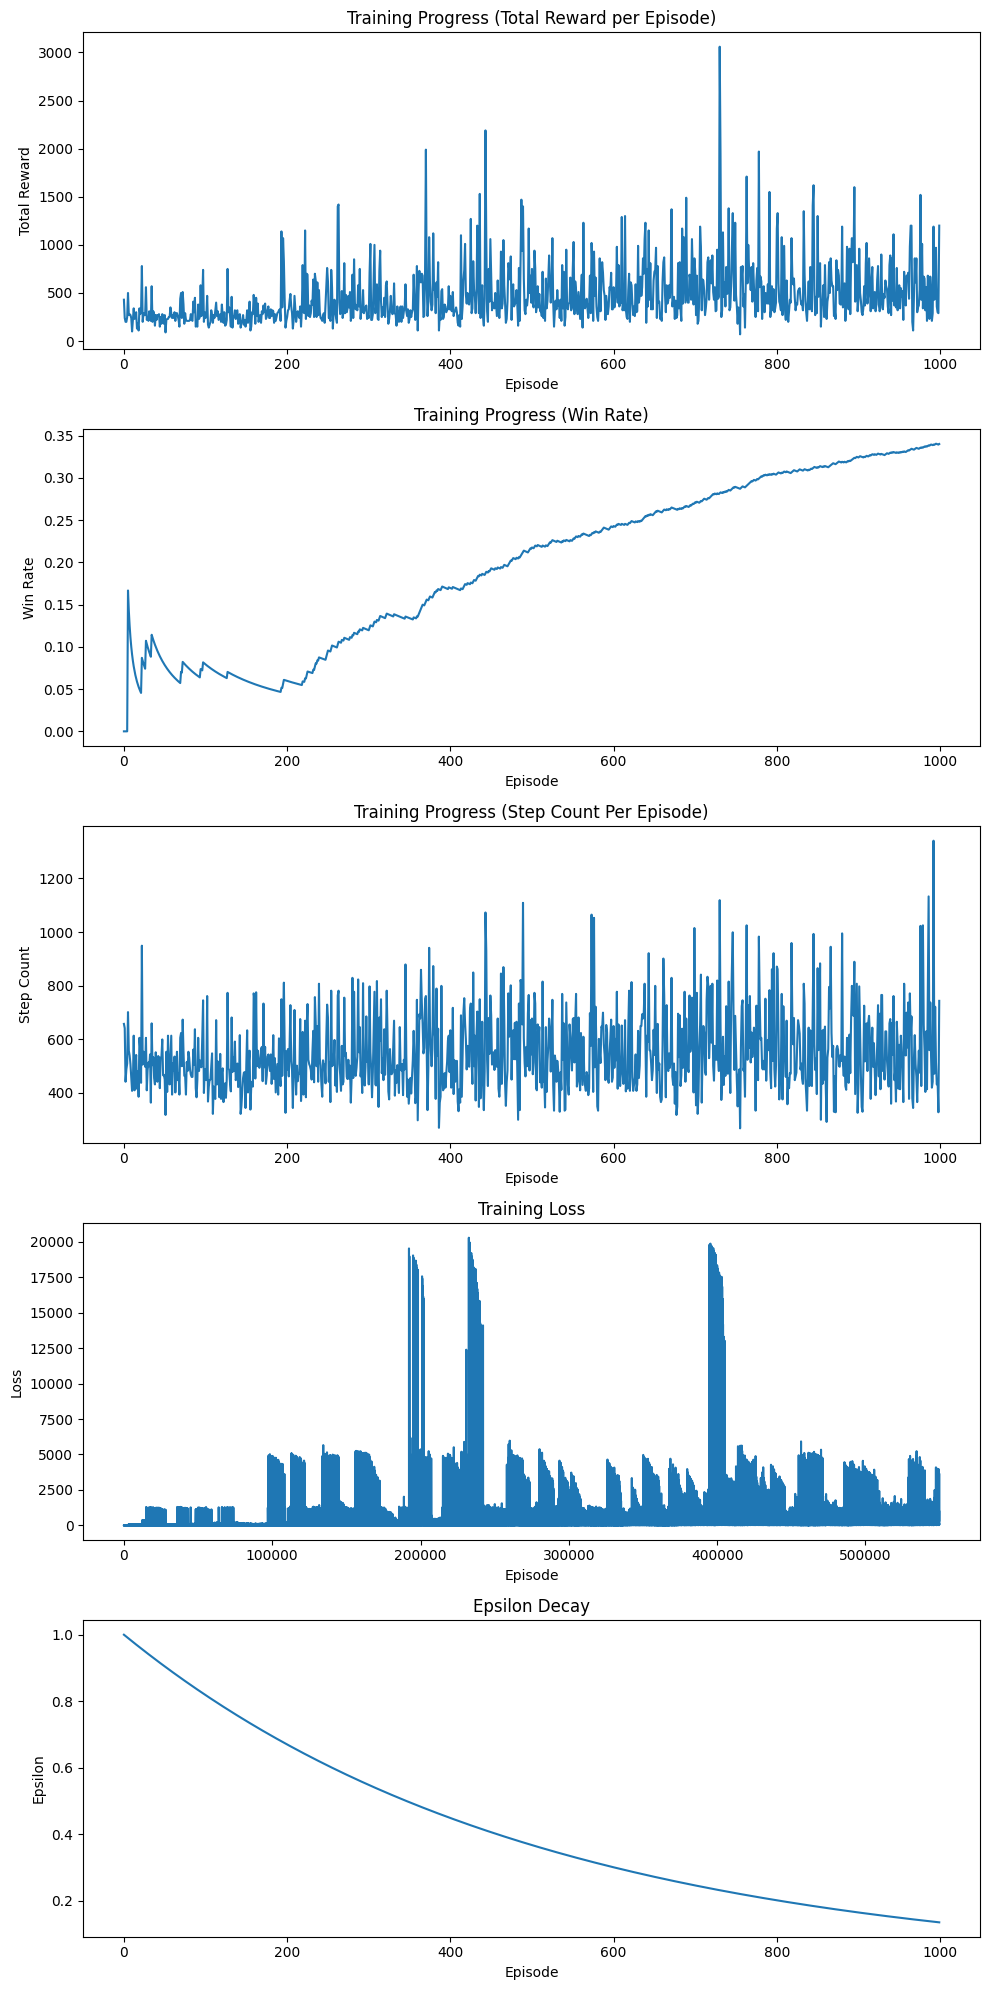

In [ ]:
# Hyperparameters
GAMMA_1 = 0.99
LEARNING_RATE_1 = 1e-4
BUFFER_SIZE_1 = 10000
BATCH_SIZE_1 = 32
EPSILON_DECAY_1 = 0.998
EPSILON_MIN_1 = 0.05
TARGET_UPDATE_1 = 1000
NUM_EPISODES_1 = 1000
FRAME_STACK_1 = 4
WIN_REWARD_THRESHOLD_1 = 500
# Initializing the training for experiment 1
train(GAMMA_1,
LEARNING_RATE_1,
BUFFER_SIZE_1,
BATCH_SIZE_1,
TARGET_UPDATE_1,
NUM_EPISODES_1,
FRAME_STACK_1,
WIN_REWARD_THRESHOLD_1,FILENAME='pacman_dqn_experiment_1.pth')

#### **<u>Training Results for Experiment 1: Interpretation</u>**

1. **Reward Progression Shows Gradual Improvement**  
   The "Total Reward per Episode" plot demonstrates a slight upward trend over the course of 1000 episodes. Although there is significant variance in individual rewards, the average reward increases steadily from ~278 at episode 100 to ~555 by episode 1000.

2. **Win Rate Shows Positive Learning Trend**  
   The "Win Rate" plot reveals a consistent increase throughout training, indicating that the agent is progressively learning better strategies. By episode 1000, the win rate reaches approximately 0.34, suggesting improved but still suboptimal performance.

3. **Step Count per Episode Slightly Increases**  
   The "Step Count per Episode" plot remains mostly stable with mild upward movement, indicating that the agent survives longer on average as training progresses. This is corroborated by the average steps increasing from ~510 at episode 100 to ~573 at episode 1000.

4. **Training Loss is Spiky but Shows Decreasing Spikes**  
   The "Training Loss" plot exhibits large fluctuations, especially in earlier stages, indicating unstable learning. However, the frequency and magnitude of these spikes tend to decrease over time, suggesting convergence and better policy refinement as training continues.

5. **Epsilon Decay is Smooth and Effective**  
   The "Epsilon Decay" plot confirms a typical exploration-to-exploitation transition. Epsilon decreases smoothly from 1.0 to 0.1351 across 1000 episodes, aligning with the improved reward and win rate patterns, as the agent exploits learned behavior more over time.

### 13. Evaluating the Experiment 1

In [ ]:
evaluate_agent( FRAME_STACK = FRAME_STACK_1, WIN_REWARD_THRESHOLD = WIN_REWARD_THRESHOLD_1, fileName = 'pacman_dqn_experiment_1.pth', videoName = 'pacman_video_experiment_1.mp4')

Episode 1: Reward = 670.0, Steps = 753
Episode 2: Reward = 660.0, Steps = 627
Episode 3: Reward = 650.0, Steps = 717
Episode 4: Reward = 650.0, Steps = 717
Episode 5: Reward = 680.0, Steps = 927
Episode 6: Reward = 280.0, Steps = 537
Episode 7: Reward = 850.0, Steps = 617
Episode 8: Reward = 2110.0, Steps = 821
Episode 9: Reward = 280.0, Steps = 537


Episode 10: Reward = 280.0, Steps = 537
Sample gameplay video saved to /content/drive/MyDrive/pacman/evaluation_pacman_video.mp4

--- Evaluation Results ---
Average Reward: 711.00
Average Steps: 679.00
Win Rate (reward >= 500): 70.00%


### 14. Running the Second Experiment
##### **<u>Hyperparameters for Second Experiment</u>**

- **GAMMA**: 0.99  
  - The discount factor for future rewards. It determines the importance of future rewards in comparison to immediate rewards. A value of 0.99 means the agent values future rewards quite highly.

- **LEARNING_RATE**: 1e-4  
  - The learning rate for optimizing the model's weights during training. A smaller learning rate, such as 1e-4, ensures gradual updates to the model, leading to more stable convergence.

- **BUFFER_SIZE**: 10,000  
  - The size of the replay buffer where past experiences are stored. A buffer size of 10,000 allows the agent to learn from a larger variety of past experiences, improving the model's generalization ability.

- **BATCH_SIZE**: 32  
  - The number of experiences sampled from the replay buffer for each training step. A batch size of 32 strikes a balance between training stability and computation efficiency.

- **EPSILON_DECAY**: 0.995  
  - The decay rate for epsilon in the epsilon-greedy strategy. The epsilon value decreases over time, reducing the exploration rate. A decay rate of 0.995 results in slower reduction in exploration, allowing the agent more opportunities to explore early on.

- **EPSILON_MIN**: 0.05  
  - The minimum value for epsilon. This ensures that even after the decay process, the agent will always explore at least 5% of the time, preventing it from becoming too greedy.

- **TARGET_UPDATE**: 1000  
  - The frequency at which the target network is updated to match the policy network. This is done to ensure the stability of the training process, updating every 1000 episodes.

- **NUM_EPISODES**: 500  
  - The total number of episodes to train the agent. The agent's policy is updated after each episode, and the total training is carried out for 500 episodes in this experiment.

- **FRAME_STACK**: 4  
  - The number of frames to stack together as input to the model. Stacking 4 frames allows the model to account for temporal dependencies in the game, which is important for tasks like controlling Pac-Man where movement is continuous over time.

- **WIN_REWARD_THRESHOLD**: 500  
  - The reward threshold for an episode to be considered a win during evaluation. If the agent earns a reward greater than or equal to 500 in an episode, it is counted as a win.


In [ ]:
# Hyperparameters
GAMMA_2 = 0.99
LEARNING_RATE_2 = 1e-4
BUFFER_SIZE_2 = 10000
BATCH_SIZE_2 = 32
EPSILON_DECAY_2 = 0.995
EPSILON_MIN_2 = 0.05
TARGET_UPDATE_2 = 1000
NUM_EPISODES_2 = 500
FRAME_STACK_2 = 4
WIN_REWARD_THRESHOLD_2 = 500

No checkpoint found, starting from scratch.
Episode 100: Avg Reward = 311.30, Avg Steps = 512.36, Epsilon = 0.6058
Checkpoint saved at episode 100 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 200: Avg Reward = 533.90, Avg Steps = 572.04, Epsilon = 0.3670
Checkpoint saved at episode 200 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 300: Avg Reward = 593.00, Avg Steps = 578.12, Epsilon = 0.2223
Checkpoint saved at episode 300 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 400: Avg Reward = 588.70, Avg Steps = 592.22, Epsilon = 0.1347
Checkpoint saved at episode 400 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth
Episode 500: Avg Reward = 627.50, Avg Steps = 612.72, Epsilon = 0.0816
Checkpoint saved at episode 500 to /content/drive/MyDrive/pacman/dqn_checkpoints/checkpoint.pth


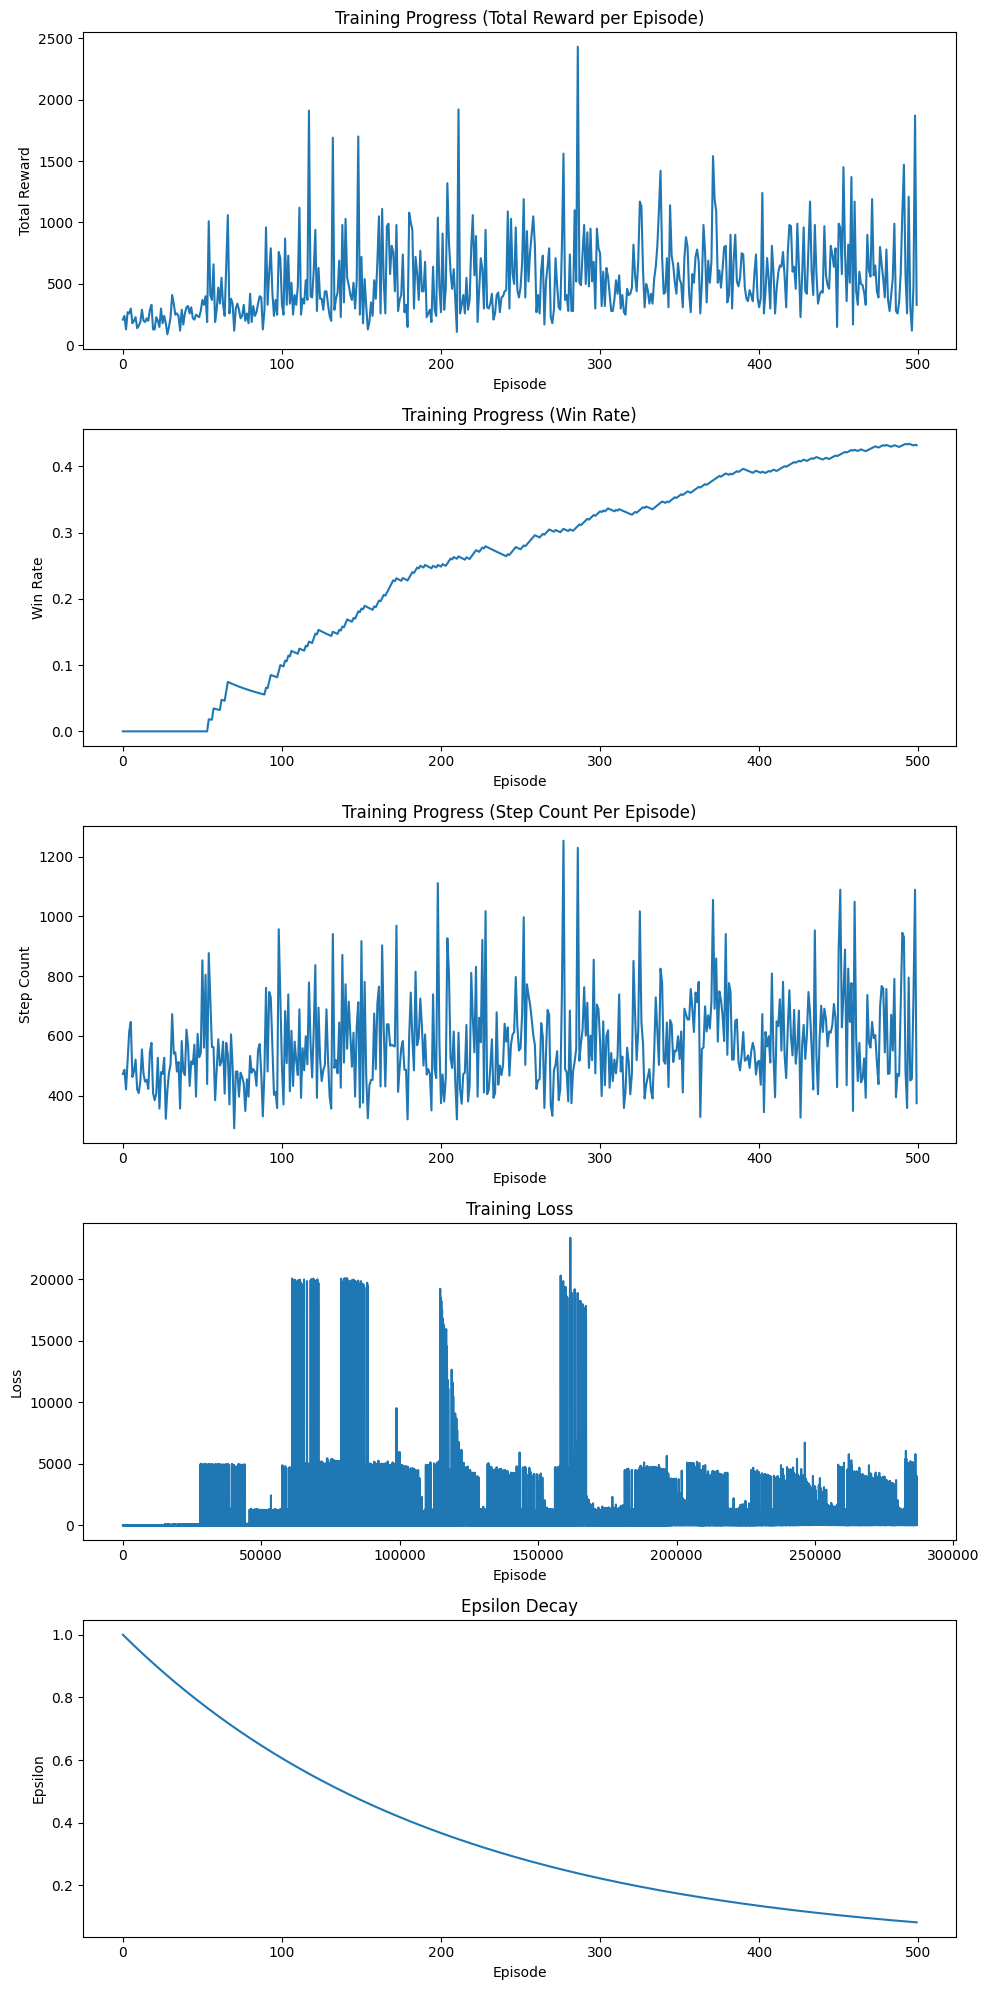

In [ ]:
train(GAMMA_2,
      LEARNING_RATE_2,
      BUFFER_SIZE_2,
      BATCH_SIZE_2,
      TARGET_UPDATE_2,
      WIN_REWARD_THRESHOLD_2,
      EPSILON_MIN_2,
      EPSILON_DECAY_2,
      NUM_EPISODES_2,
      FRAME_STACK_2,
      FILENAME = 'pacman_dqn_experiment_2.pth')

#### **<u>Training Results for Experiment 2: Interpretation</u>**

1. **Consistent Reward Improvement Across Episodes**  
   The "Total Reward per Episode" plot shows a clear upward trend over the 500 episodes. The agent's average reward increased from ~311 at episode 100 to ~627 at episode 500, indicating strong learning and performance enhancement.

2. **Win Rate Significantly Improved**  
   The "Win Rate" plot rises steadily, surpassing 0.4 by the end of training. This confirms that the agent is learning effective strategies and achieving wins more consistently as training progresses.

3. **Episode Step Count is Increasing**  
   The "Step Count per Episode" also trends upward, suggesting that the agent is surviving longer and possibly completing more tasks per episode. The average steps rose from ~512 to ~613 by episode 500.

4. **Training Loss Shows Stabilization Trend**  
   The "Training Loss" plot initially displays large spikes, similar to Experiment 1, but these spikes decrease over time. This behavior suggests that the learning process becomes more stable as the agent gains experience.

5. **Effective Exploration-to-Exploitation Shift**  
   The "Epsilon Decay" curve shows a steady drop from 1.0 to 0.0816 over 500 episodes. This indicates a successful transition from exploration to exploitation, which aligns with the observed improvements in reward and win rate.

### 15. Evaluating the Experiment 2

In [ ]:
evaluate_agent( FRAME_STACK = FRAME_STACK_2, WIN_REWARD_THRESHOLD = WIN_REWARD_THRESHOLD_2, fileName = 'pacman_dqn_experiment_2.pth', videoName = 'pacman_video_experiment_2.mp4')

Episode 1: Reward = 240.0, Steps = 455
Episode 2: Reward = 250.0, Steps = 473
Episode 3: Reward = 170.0, Steps = 461
Episode 4: Reward = 170.0, Steps = 461
Episode 5: Reward = 190.0, Steps = 459
Episode 6: Reward = 240.0, Steps = 443
Episode 7: Reward = 170.0, Steps = 469
Episode 8: Reward = 240.0, Steps = 455
Episode 9: Reward = 250.0, Steps = 495


Episode 10: Reward = 200.0, Steps = 483
Sample gameplay video saved to /content/drive/MyDrive/pacman/evaluation_pacman_video.mp4

--- Evaluation Results ---
Average Reward: 212.00
Average Steps: 465.40
Win Rate (reward >= 500): 0.00%


### 16. Experiment Details

#### **<u>Experiment Hyperparameter Comparison</u>**

| **Hyperparameters**               | **Experiment 1**                                                                                             | **Experiment 2**                                                                                             |
|------------------------------|-------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **GAMMA**                     | 0.99                                                                                                        | 0.99                                                                                                        |
| **LEARNING_RATE**             | 1e-4                                                                                                        | 1e-4                                                                                                        |
| **BUFFER_SIZE**               | 10000                                                                                                       | 10000                                                                                                       |
| **BATCH_SIZE**                | 32                                                                                                          | 32                                                                                                          |
| **EPSILON_DECAY**             | 0.998                                                                                                       | 0.995                                                                                                       |
| **EPSILON_MIN**               | 0.05                                                                                                        | 0.05                                                                                                        |
| **TARGET_UPDATE**             | 1000                                                                                                        | 1000                                                                                                        |
| **NUM_EPISODES**              | 1000                                                                                                        | 500                                                                                                         |
| **FRAME_STACK**               | 4                                                                                                           | 4                                                                                                           |
| **WIN_REWARD_THRESHOLD**      | 500                                                                                                         | 500                                                                                                         |




#### **<u>Experiment Results Comparison</u>**

| **Metric**               | **Experiment 1**                                                                                             | **Experiment 2**                                                                                             |
|------------------------------|-------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **Episode 100 - Avg Reward**  | 278.10                                                                                                      | 311.30                                                                                                      |
| **Episode 100 - Avg Steps**   | 509.70                                                                                                      | 512.36                                                                                                      |
| **Episode 100 - Epsilon**     | 0.8186                                                                                                      | 0.6058                                                                                                      |
| **Episode 500 - Avg Reward**  | 540.70                                                                                                      | 627.50                                                                                                      |
| **Episode 500 - Avg Steps**   | 572.64                                                                                                      | 612.72                                                                                                      |
| **Episode 500 - Epsilon**     | 0.3675                                                                                                      | 0.0816                                                                                                      |
| **Evaluation - Avg Reward**   | 711.00                                                                                                      | 220.00                                                                                                      |
| **Evaluation - Avg Steps**    | 679.00                                                                                                      | 468.00                                                                                                      |
| **Evaluation - Win Rate**     | 70.00% (reward >= 500)                                                                                      | 0.00% (reward >= 500)                                                                                        |


#### **<u>Experiment Observations</u>**

| **Metric**                        | **Experiment 1**                                                                                     | **Experiment 2**                                                                                      |
|-----------------------------------|-----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Training Duration**             | 1000 episodes, more time to improve the agent’s performance.                                          | 500 episodes, shorter training duration, which led to lower performance compared to Experiment 1.     |
| **Epsilon Decay**                 | Faster decay rate (0.998), leading to quicker exploitation of learned strategies.                    | Slower decay rate (0.995), resulting in more exploration at later stages, which slowed down learning. |
| **Performance (Episode 100)**     | Avg Reward = 278.10, Avg Steps = 509.70, Epsilon = 0.8186                                           | Avg Reward = 311.30, Avg Steps = 512.36, Epsilon = 0.6058                                           |
| **Performance (Episode 500)**     | Avg Reward = 540.70, Avg Steps = 572.64, Epsilon = 0.3675                                           | Avg Reward = 627.50, Avg Steps = 612.72, Epsilon = 0.0816                                           |
| **Evaluation (Avg Reward)**       | 711.00, indicating the agent reached high performance.                                               | 220.00, significantly lower performance, struggling to reach the win threshold.                       |
| **Evaluation (Win Rate)**         | 70.00%, a strong win rate, showing that the agent consistently performed well in evaluation episodes. | 0.00%, failed to win in any evaluation episodes.                                                      |
| **Key Takeaway**                  | Longer training duration and faster epsilon decay resulted in better performance and a higher win rate. | Shorter training duration and slower epsilon decay led to lower performance and no wins.             |


### 17. Future Enhancements

- **Increase Replay Buffer Size**  
  Expand the replay buffer from 10,000 to 100,000 or more to store a broader range of experiences. A larger buffer helps the agent learn from a more diverse and richer set of transitions, which is crucial for complex environments like MsPacman.

- **Update Target Network Less Frequently**  
  Change the target network update interval from every 1000 steps to every 5000–10000 steps. Less frequent updates lead to more stable Q-value targets, reducing fluctuations during learning.

- **Train for More Episodes**  
  Extend training from 500 or 1000 episodes to at least 5000 episodes. This gives the agent more time to explore and learn, improving overall performance and policy generalization.

- **Implement Prioritized Experience Replay (PER)**  
  Integrate PER to sample important transitions more frequently based on their TD-error. This leads to better learning efficiency by emphasizing critical experiences over less informative ones.


Note: All these changes require high computational resources which we currently don't have so that is why we did not implement these